# Exploratory Data Analysis

In [1]:
import os
import random
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import scipy.io as sio

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.transforms.functional as TF

from tqdm import tqdm
import wandb 
import scipy.ndimage as ndi

In [2]:
IMG1 = os.path.join("dataset", "lizard_images1", "Lizard_Images1")
IMG2 = os.path.join("dataset", "lizard_images2", "Lizard_Images2")
LABELS = os.path.join("dataset", "lizard_labels", "Lizard_Labels", "Labels")
INFO = os.path.join("dataset", "lizard_labels", "Lizard_Labels", "info.csv")
OVERLAY = os.path.join("dataset", "overlay", "Overlay")

# EDA

In [3]:
# info.csv
df = pd.read_csv(INFO)
df.head()

Filename                                             Source  Split
0  dpath_1  1800127001_2019-04-30 10_40_02-lv1-1001-22444-...      3
1  dpath_2  1902160001_2019-06-11 12_36_32-lv1-39045-16016...      2
2  dpath_3  2019_03867_1-1_2019-02-20 20_00_32-lv1-35269-3...      3
3  dpath_4  2019-07501-1-1-1_2019-05-29 08_22_25-lv1-9661-...      1
4  dpath_5  2018_83220_1-1_2019-02-20 18_33_11-lv1-58151-3...      2

In [4]:
len(df)

238

> The dataset is already split into train, validatioan and test parts

In [5]:
# Count Images and Labels

images1 = sorted(glob(os.path.join(IMG1, "*.*")))
images2 = sorted(glob(os.path.join(IMG2, "*.*")))
labels_files = sorted(glob(os.path.join(LABELS, "*.*")))
overlay_files = sorted(glob(os.path.join(OVERLAY, "*.*")))

print("Images1:", len(images1))
print("Images2:", len(images2))
print("Labels:", len(labels_files))
print("Overlay:", len(overlay_files))

Images1: 80
Images2: 158
Labels: 238
Overlay: 238


> - The dataset (.png) is split into 2 folders 
> - All the labels (.mat) are located in one folder
> - Overlay files (.jpg) are also located in one folder

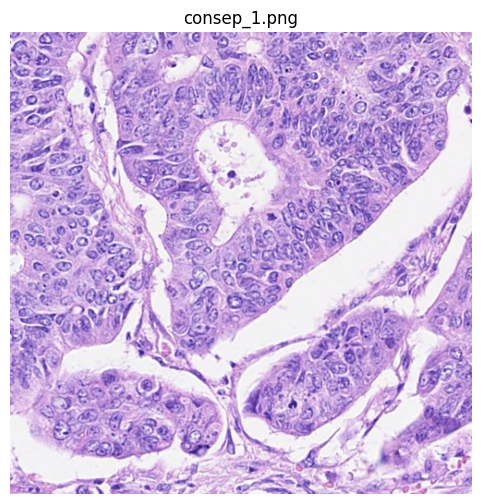

In [6]:
# Show Image

def show_image(path):
    img = np.array(Image.open(path))
    plt.figure(figsize=(6,6))
    plt.title(os.path.basename(path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


show_image(images1[0])

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


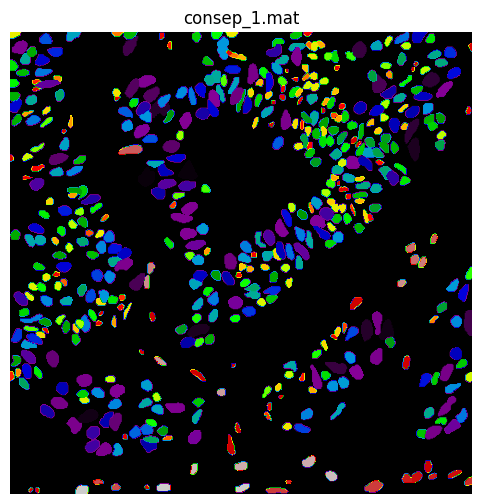

Nuclei in this image: 528


In [7]:
# Show Label

def show_label(path):
    mask_data = sio.loadmat(path)

    print(mask_data.keys())  # see what arrays are inside

    inst_map = mask_data['inst_map']  

    plt.figure(figsize=(6,6))
    plt.imshow(inst_map, cmap='nipy_spectral')
    plt.axis('off')
    plt.title(os.path.basename(path))
    plt.show()

    nuclei_count = len(np.unique(inst_map)) - 1  # subtract 0 (background)
    print("Nuclei in this image:", nuclei_count)


show_label(labels_files[0])

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


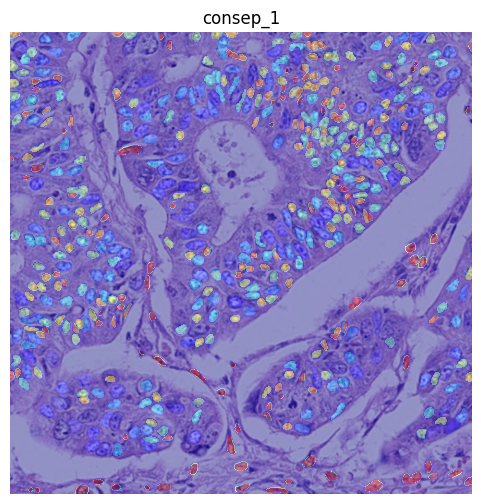

In [8]:
# Overlay Image and Mask

def overlay(img_path, mask_path):
    img = np.array(Image.open(img_path))

    mat = sio.loadmat(mask_path)
    
    print(mat.keys())  # first, to see what key holds your mask
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]  # take first non-meta key
    mask = mat[mask_key]

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='jet')
    plt.title(os.path.basename(img_path).split('.')[0])
    plt.axis('off')
    plt.show()


overlay(images1[0], labels_files[0])


dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


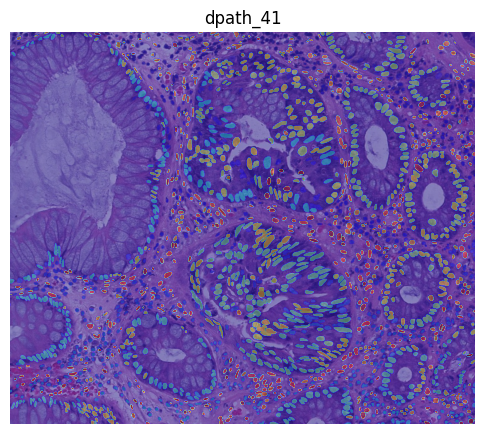

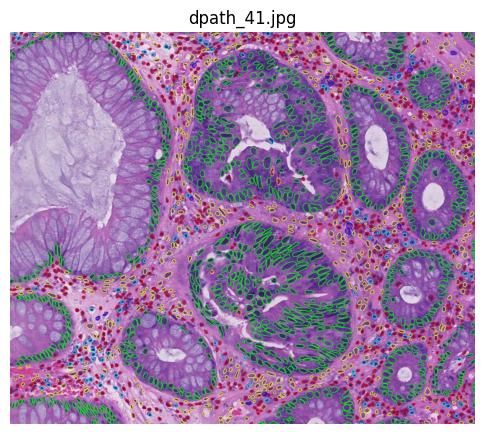

In [9]:
# Overlay random image to check constintancy

random_image = random.choice(images1 + images2)

def get_mask_path(img_path):
    img_name = os.path.basename(img_path).split('.')[0]
    mask_path = os.path.join(LABELS, img_name + ".mat")
    return mask_path

# Image + Label
overlay(random_image, get_mask_path(random_image))

# Overlay from dataset
overlay_img_path = os.path.join(OVERLAY, os.path.basename(random_image).split('.')[0] + ".jpg")
show_image(overlay_img_path)


> I ran this several times and didnt find any inconsistances between overlay files and coresponding combined image + mask

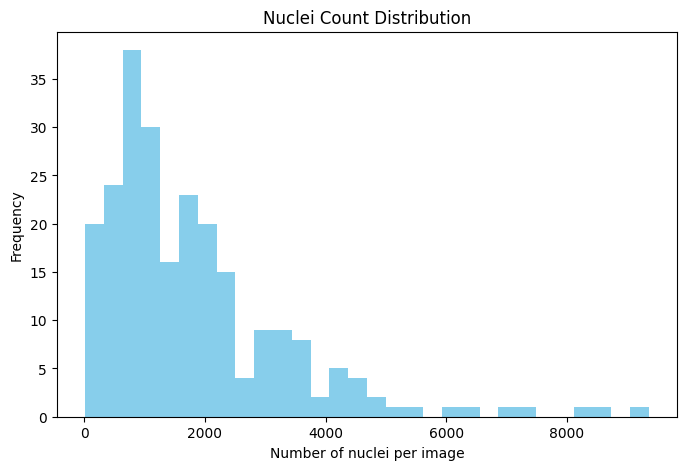

In [10]:
# Number of nuclei per image

nuclei_counts = []
for mask_path in labels_files:
    mat = sio.loadmat(mask_path)
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]
    mask = mat[mask_key]
    count = len(np.unique(mask)) - 1  # subtract background
    nuclei_counts.append(count)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(nuclei_counts, bins=30, color='skyblue')
plt.xlabel("Number of nuclei per image")
plt.ylabel("Frequency")
plt.title("Nuclei Count Distribution")  
plt.show()

> There are some outliers (several images have too many nuclei compared to the others)

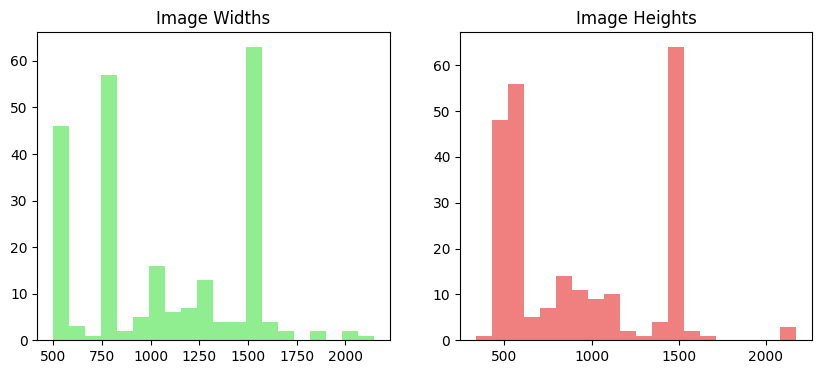

In [11]:
# Image Sizes

img_sizes = [Image.open(p).size for p in images1 + images2]
widths, heights = zip(*img_sizes)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, color='lightgreen')
plt.title("Image Widths")

plt.subplot(1,2,2)
plt.hist(heights, bins=20, color='lightcoral')
plt.title("Image Heights")
plt.show()


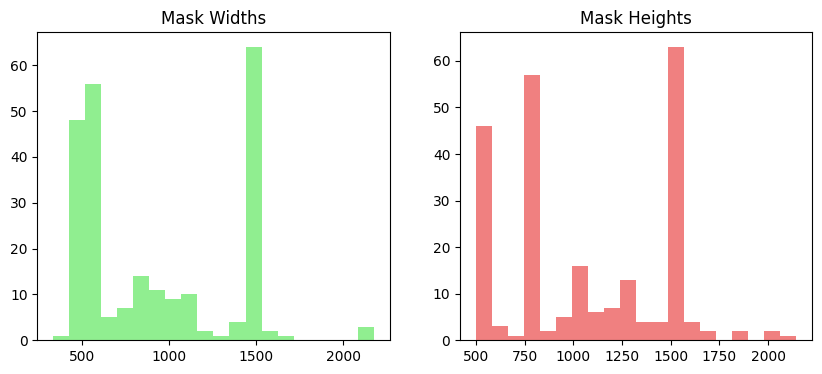

In [12]:
# Mask Sizes

mask_shapes = []
for mask_path in labels_files:
    mat = sio.loadmat(mask_path)
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]
    mask = mat[mask_key]
    mask_shapes.append(mask.shape)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist([s[0] for s in mask_shapes], bins=20, color='lightgreen')
plt.title("Mask Widths")

plt.subplot(1,2,2)
plt.hist([s[1] for s in mask_shapes], bins=20, color='lightcoral')
plt.title("Mask Heights")
plt.show()

> Image sizes differ from one another (needs addressing)

# Data preprocessing and normalization

In [13]:
# derive sub-dataset name from filename
df["Dataset"] = df["Filename"].str.split("_").str[0]
print(df[["Filename", "Dataset"]].head())

  Filename Dataset
0  dpath_1   dpath
1  dpath_2   dpath
2  dpath_3   dpath
3  dpath_4   dpath
4  dpath_5   dpath


In [14]:
#  80/10/10 split
rng = np.random.default_rng(42)         
new_split = np.zeros(len(df), dtype=int)

for name, group in df.groupby("Dataset"):
    idx = group.index.to_numpy()
    rng.shuffle(idx)                  

    n = len(idx)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)
    n_test = n - n_train - n_val         

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    new_split[train_idx] = 1           
    new_split[val_idx]   = 2            
    new_split[test_idx]  = 3            

df["Split"] = new_split  

split_counts = df["Split"].value_counts().sort_index()
print("Split (80/10/10 per Dataset):")
print(f"Split 1 - Train:      {split_counts.get(1, 0)}")
print(f"Split 2 - Validation: {split_counts.get(2, 0)}")
print(f"Split 3 - Test:       {split_counts.get(3, 0)}")

Split (80/10/10 per Dataset):
Split 1 - Train:      188
Split 2 - Validation: 21
Split 3 - Test:       29


In [15]:
# transformations for images (RGB) and binary masks (0/1) – no resize here
img_transform = T.Compose([
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

mask_transform = T.Compose([
    T.PILToTensor(),  # -> [1, H, W] with values 0/255
])

In [16]:
# helper functions for loading an image and a mask from the Lizard dataset
def load_lizard_image(row, img1_dir, img2_dir):
    fname = row["Filename"]

    path1 = os.path.join(img1_dir, fname + ".png")
    path2 = os.path.join(img2_dir, fname + ".png")

    if os.path.exists(path1):
        path = path1
    elif os.path.exists(path2):
        path = path2
    else:
        raise FileNotFoundError(f"Image {fname}.png sa nenašiel ani v {img1_dir}, ani v {img2_dir}")

    img = Image.open(path).convert("RGB")
    return img

def load_lizard_mask(row, labels_dir):
    fname = row["Filename"]
    mat_path = os.path.join(labels_dir, fname + ".mat")
    mat = sio.loadmat(mat_path)
    inst_map = mat["inst_map"]          # 0 = pozadie, >0 = jadro

    mask_np = (inst_map > 0).astype("uint8")  # 0/1
    mask = Image.fromarray(mask_np * 255)     # 0/255
    return mask

In [17]:
# helper functions to crop image + mask from original resolution (keep details)
PATCH_SIZE = 512  

def _ensure_min_size(img, mask, size):
    if isinstance(size, int):
        th = tw = size
    else:
        th, tw = size

    w, h = img.size  # PIL: (W, H)
    if h >= th and w >= tw:
        return img, mask

    scale = max(th / h, tw / w)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    img = img.resize((new_w, new_h), resample=Image.BILINEAR)
    mask = mask.resize((new_w, new_h), resample=Image.NEAREST)
    return img, mask


def random_crop_pair(img, mask, size=PATCH_SIZE):
    if isinstance(size, int):
        th = tw = size
    else:
        th, tw = size

    img, mask = _ensure_min_size(img, mask, (th, tw))
    w, h = img.size

    i = torch.randint(0, h - th + 1, (1,)).item()
    j = torch.randint(0, w - tw + 1, (1,)).item()

    img = TF.crop(img, i, j, th, tw)
    mask = TF.crop(mask, i, j, th, tw)
    return img, mask


def center_crop_pair(img, mask, size=PATCH_SIZE):
    if isinstance(size, int):
        th = tw = size
    else:
        th, tw = size

    img, mask = _ensure_min_size(img, mask, (th, tw))
    w, h = img.size

    i = max(0, (h - th) // 2)
    j = max(0, (w - tw) // 2)

    img = TF.crop(img, i, j, th, tw)
    mask = TF.crop(mask, i, j, th, tw)
    return img, mask

In [18]:
# helper function to apply the same random augmentations to image and mask
def apply_augmentations(img, mask, flip_h, flip_v, rotate):
    seed = torch.randint(0, 2**32, (1,)).item()

    torch.manual_seed(seed)
    img = flip_h(img)
    torch.manual_seed(seed)
    mask = flip_h(mask)

    torch.manual_seed(seed)
    img = flip_v(img)
    torch.manual_seed(seed)
    mask = flip_v(mask)

    torch.manual_seed(seed)
    img = rotate(img)
    torch.manual_seed(seed)
    mask = rotate(mask)

    return img, mask

In [19]:
# dataset class for Lizard – binary segmentation (0 = background, 1 = nucleus)
class LizardSegmentationDataset(Dataset):
    def __init__(self, df, split_id, img1_dir, img2_dir, labels_dir,
                 img_transform=None, mask_transform=None, augment=False):
        # select rows according to Split column (1 = train, 2 = val, 3 = test)
        self.df = df[df["Split"] == split_id].reset_index(drop=True)

        self.img1_dir = img1_dir
        self.img2_dir = img2_dir
        self.labels_dir = labels_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.augment = augment
        self.is_train = (split_id == 1)  # training split

        # geometric augmentations 
        self.flip_h = T.RandomHorizontalFlip(p=0.5)
        self.flip_v = T.RandomVerticalFlip(p=0.5)
        self.rotate = T.RandomRotation(degrees=10)

        self.patch_size = PATCH_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1) load full-resolution image and mask
        img = load_lizard_image(row, self.img1_dir, self.img2_dir)
        mask = load_lizard_mask(row, self.labels_dir)

        # 2) crop from original resolution (random for train, center for val/test)
        if self.is_train:
            img, mask = random_crop_pair(img, mask, self.patch_size)
        else:
            img, mask = center_crop_pair(img, mask, self.patch_size)

        # 3) optional augmentations (flips + small rotation) – only for train
        if self.augment:
            img, mask = apply_augmentations(img, mask, self.flip_h, self.flip_v, self.rotate)

        # 4) transform to tensors and normalise
        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)  # [1, H, W], values 0/255

        # 5) convert mask to {0,1} long tensor
        mask = (mask > 0).long()

        return img, mask

In [20]:
# hyperparameters for the segmentation model
config = {
    "image_size": 512,
    "batch_size": 5,
    "num_epochs": 30,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "optimizer": "adam",
    "loss": "dice_bce",   
    "model_name": "unet_lizard_baseline",
    "patience": 5,  
}

In [21]:
# create train/validation/test datasets according to the predefined Split (1/2/3)
train_ds = LizardSegmentationDataset(
    df=df,
    split_id=1,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=True,
)

val_ds = LizardSegmentationDataset(
    df=df,
    split_id=2,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=False,
)

test_ds = LizardSegmentationDataset(
    df=df,
    split_id=3,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=False,
)

In [22]:
# dataloaders for train/validation/test splits
train_loader = DataLoader(
    train_ds,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=0,     
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,      
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,      
    pin_memory=True,
)

In [23]:
print("len(train_ds) =", len(train_ds))
print("len(val_ds)   =", len(val_ds))
print("len(test_ds)  =", len(test_ds))

sample_img, sample_mask = train_ds[0]
print("sample_img:", sample_img.shape)
print("sample_mask:", sample_mask.shape)

len(train_ds) = 188
len(val_ds)   = 21
len(test_ds)  = 29
sample_img: torch.Size([3, 512, 512])
sample_mask: torch.Size([1, 512, 512])


In [24]:
# check batch shapes – prepared for U-Net / transformer
batch_imgs, batch_masks = next(iter(train_loader))
print("Images:", batch_imgs.shape)  
print("Masks: ", batch_masks.shape) 

Images: torch.Size([5, 3, 512, 512])
Masks:  torch.Size([5, 1, 512, 512])


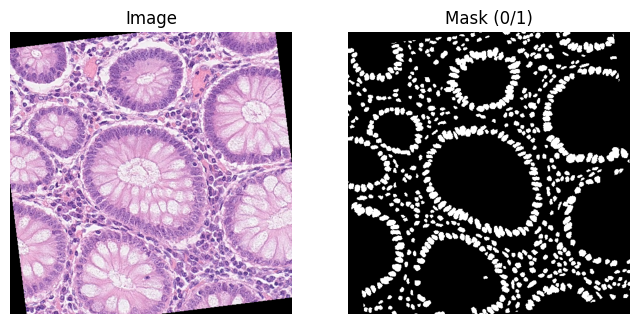

In [25]:
# visualize a single image–mask pair from a training batch
idx = 0

img_np = batch_imgs[idx].permute(1, 2, 0).detach().cpu().numpy()
img_np = (img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

mask_np = batch_masks[idx][0].detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.axis("off")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="gray")
plt.axis("off")
plt.title("Mask (0/1)")
plt.show()

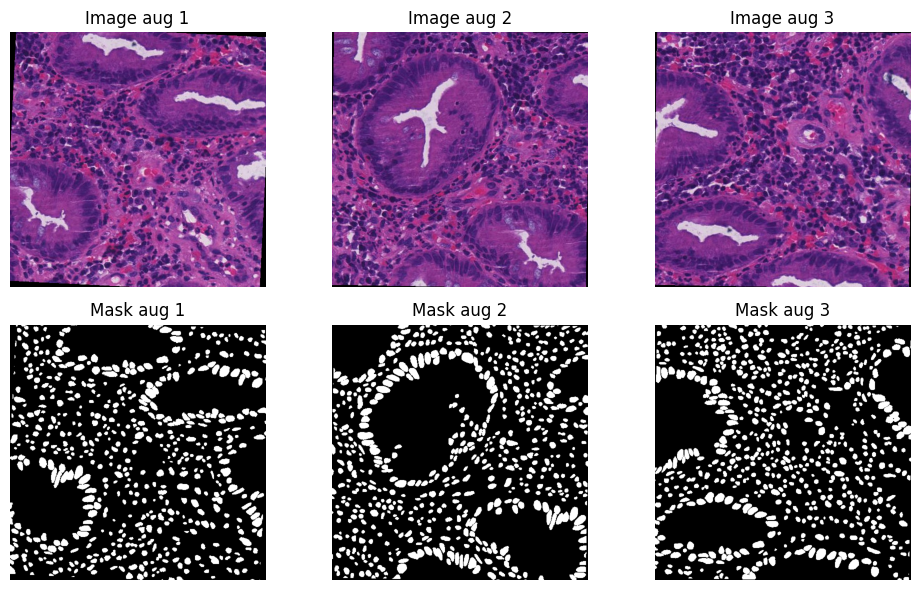

In [26]:
# visualize data augmentations – same sample from train_ds shown multiple times
idx = 0 

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for i in range(3):
    img, mask = train_ds[idx] 

    img_np = img.permute(1, 2, 0).detach().cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
    mask_np = mask[0].detach().cpu().numpy()

    axes[0, i].imshow(img_np)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Image aug {i+1}")

    axes[1, i].imshow(mask_np, cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Mask aug {i+1}")

plt.tight_layout()
plt.show()

# Configuration

In [27]:
# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU name:", torch.cuda.get_device_name(0))

Using device: cuda
GPU name: NVIDIA GeForce GTX 1650


In [28]:
#random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [29]:
# where to save models, logs and predictions
OUTPUT_DIR = "outputs"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
LOG_DIR = os.path.join(OUTPUT_DIR, "logs")
PRED_DIR = os.path.join(OUTPUT_DIR, "predictions")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)

print("Model dir:", MODEL_DIR)
print("Log dir:", LOG_DIR)
print("Predictions dir:", PRED_DIR)

Model dir: outputs\models
Log dir: outputs\logs
Predictions dir: outputs\predictions


In [30]:
#placeholder for Weights & Biases
use_wandb = True    
wandb_project = "zneus-lizard-segmentation"
wandb_run_name = config["model_name"]

print("W&B enabled:", use_wandb)
print("W&B project:", wandb_project)
print("W&B run name:", wandb_run_name)

W&B enabled: True
W&B project: zneus-lizard-segmentation
W&B run name: unet_lizard_baseline


Metrics:
- Dice score
- IoU (Intersection over Union)
- precision / recall z TP/FP/FN/TN po pixeloch
- accuracy

# Experiments 

In [31]:
# evaluation metrics for binary segmentation (pixel-wise)
def compute_confusion_counts(preds, targets):
    preds = preds.view(-1).float()
    targets = targets.view(-1).float()

    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()
    fn = ((1 - preds) * targets).sum()
    tn = ((1 - preds) * (1 - targets)).sum()
    return tp, fp, fn, tn


def dice_score(preds, targets, eps=1e-7):
    tp, fp, fn, _ = compute_confusion_counts(preds, targets)
    return (2 * tp + eps) / (2 * tp + fp + fn + eps)


def iou_score(preds, targets, eps=1e-7):
    tp, fp, fn, _ = compute_confusion_counts(preds, targets)
    return (tp + eps) / (tp + fp + fn + eps)


def pixel_accuracy(preds, targets, eps=1e-7):
    tp, fp, fn, tn = compute_confusion_counts(preds, targets)
    return (tp + tn + eps) / (tp + tn + fp + fn + eps)


def precision_recall(preds, targets, eps=1e-7):
    tp, fp, fn, _ = compute_confusion_counts(preds, targets)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    return precision, recall


In [32]:
# loss functions – Dice + BCE + Focal 
bce_loss = nn.BCEWithLogitsLoss()

class FocalLossWithLogits(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()

        # p_t = p ak y=1, inak 1-p
        pt = probs * targets + (1.0 - probs) * (1.0 - targets)
        alpha_t = self.alpha * targets + (1.0 - self.alpha) * (1.0 - targets)
        focal_weight = alpha_t * (1.0 - pt).pow(self.gamma)

        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

focal_loss = FocalLossWithLogits(alpha=0.25, gamma=2.0, reduction="mean")

def dice_loss_from_logits(logits, targets, eps: float = 1e-7):
    probs = torch.sigmoid(logits)
    preds = probs.view(probs.size(0), -1)
    targets_flat = targets.float().view(targets.size(0), -1)

    intersection = (preds * targets_flat).sum(dim=1)
    union = preds.sum(dim=1) + targets_flat.sum(dim=1)
    dice = (2.0 * intersection + eps) / (union + eps)

    return 1.0 - dice.mean()  

def combined_loss(
    logits,
    targets,
    bce_weight: float = 0.3,
    focal_weight: float = 0.2,
    dice_weight: float = 0.5,
):

    targets = targets.float()

    bce = bce_loss(logits, targets)
    foc = focal_loss(logits, targets)
    d_loss = dice_loss_from_logits(logits, targets)

    loss = bce_weight * bce + focal_weight * foc + dice_weight * d_loss
    return loss

In [33]:
# Residual DoubleConv block for U-Net encoder/decoder
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout: float = 0.1, use_residual: bool = True):
        super().__init__()
        self.use_residual = use_residual

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
        )

        if self.use_residual:
            if in_channels == out_channels:
                self.shortcut = nn.Identity()
            else:
                self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = self.conv_block(x)
        if self.use_residual:
            skip = self.shortcut(x)
            out = out + skip
        return out

In [34]:
# Downsampling and upsampling blocks for U-Net
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout=dropout, use_residual=True),
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, dropout: float = 0.1):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels // 2, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels, dropout=dropout, use_residual=True)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2],
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [35]:
# Output convolution layer for U-Net
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [36]:
# Residual U-Net model with base_channels=48 and MC Dropout support
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int = 3,
        n_classes: int = 1,
        base_channels: int = 48,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.inc = DoubleConv(n_channels, base_channels, dropout, use_residual=True)
        self.down1 = Down(base_channels, base_channels * 2, dropout)
        self.down2 = Down(base_channels * 2, base_channels * 4, dropout)
        self.down3 = Down(base_channels * 4, base_channels * 8, dropout)
        self.down4 = Down(base_channels * 8, base_channels * 8, dropout)

        self.up1 = Up(base_channels * 16, base_channels * 4, dropout)
        self.up2 = Up(base_channels * 8, base_channels * 2, dropout)
        self.up3 = Up(base_channels * 4, base_channels, dropout)
        self.up4 = Up(base_channels * 2, base_channels, dropout)

        self.outc = OutConv(base_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

    def enable_mc_dropout(self):
        for m in self.modules():
            if isinstance(m, nn.Dropout2d):
                m.train()

In [37]:
# One training epoch with metrics computation
def train_one_epoch(model, loader, optimizer, device, threshold: float = 0.5):
    model.train()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    n_batches = 0

    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        logits = model(imgs)
        loss = combined_loss(logits, masks)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            dice = dice_score(preds, masks)
            iou = iou_score(preds, masks)

        total_loss += loss.item()
        total_dice += dice.item()
        total_iou += iou.item()
        n_batches += 1

    return total_loss / n_batches, total_dice / n_batches, total_iou / n_batches

In [38]:
# Test-time augmentation (TTA) to stabilize validation and test predictions
def _tta_predict_probabilities(model, imgs, device):
    imgs = imgs.to(device)

    with torch.no_grad():
        logits = model(imgs)
        probs = torch.sigmoid(logits)

        imgs_h = torch.flip(imgs, dims=[3])
        logits_h = model(imgs_h)
        probs_h = torch.flip(torch.sigmoid(logits_h), dims=[3])

        imgs_v = torch.flip(imgs, dims=[2])
        logits_v = model(imgs_v)
        probs_v = torch.flip(torch.sigmoid(logits_v), dims=[2])

        imgs_hv = torch.flip(imgs, dims=[2, 3])
        logits_hv = model(imgs_hv)
        probs_hv = torch.flip(torch.sigmoid(logits_hv), dims=[2, 3])

        probs_mean = (probs + probs_h + probs_v + probs_hv) / 4.0

    return probs_mean

In [39]:
# Postprocessing to remove small spurious components from predicted masks
def _postprocess_masks(preds, min_size: int = 20):
    import scipy.ndimage as ndi

    preds_np = preds.detach().cpu().numpy().astype(np.uint8)
    B, C, H, W = preds_np.shape
    cleaned = []

    for b in range(B):
        mask = preds_np[b, 0]
        labeled, num = ndi.label(mask)
        if num == 0:
            cleaned.append(mask)
            continue

        sizes = ndi.sum(mask, labeled, index=range(1, num + 1))
        sizes = np.asarray(sizes)

        remove_mask = sizes < min_size
        remove_labels = np.nonzero(remove_mask)[0] + 1

        mask_clean = mask.copy()
        for lab in remove_labels:
            mask_clean[labeled == lab] = 0

        cleaned.append(mask_clean)

    cleaned_np = np.stack(cleaned, axis=0)
    cleaned_tensor = torch.from_numpy(cleaned_np).unsqueeze(1).float()
    return cleaned_tensor.to(preds.device)

In [40]:
# Evaluation loop with optional TTA and mask postprocessing
def evaluate(
    model,
    loader,
    device,
    threshold: float = 0.5,
    use_tta: bool = True,
    min_object_size: int = 20,
):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    total_acc = 0.0
    total_prec = 0.0
    total_rec = 0.0
    n_batches = 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Eval", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = combined_loss(logits, masks)

            if use_tta:
                probs = _tta_predict_probabilities(model, imgs, device)
            else:
                probs = torch.sigmoid(logits)

            preds = (probs > threshold).float()
            preds = _postprocess_masks(preds, min_size=min_object_size)

            dice = dice_score(preds, masks)
            iou = iou_score(preds, masks)
            acc = pixel_accuracy(preds, masks)
            prec, rec = precision_recall(preds, masks)

            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou.item()
            total_acc += acc.item()
            total_prec += prec.item()
            total_rec += rec.item()
            n_batches += 1

    return {
        "loss": total_loss / n_batches,
        "dice": total_dice / n_batches,
        "iou": total_iou / n_batches,
        "accuracy": total_acc / n_batches,
        "precision": total_prec / n_batches,
        "recall": total_rec / n_batches,
    }

In [41]:
# Experiment runner with early stopping, LR scheduler and W&B logging (no AMP)
def run_experiment(exp_name, train_loader, val_loader, config, device):
    model = UNet(n_channels=3, n_classes=1).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=2,
    )

    patience = config.get("patience", 5)

    best_val_dice = 0.0
    epochs_without_improvement = 0
    best_model_path = os.path.join(MODEL_DIR, f"{exp_name}_best.pth")

    if use_wandb:
        wandb.init(
            project=wandb_project,
            name=exp_name,
            config=config,
        )
        wandb.watch(model, log="gradients", log_freq=10)

    for epoch in range(1, config["num_epochs"] + 1):
        print(f"\nEpoch {epoch}/{config['num_epochs']}")

        train_loss, train_dice, train_iou = train_one_epoch(
            model, train_loader, optimizer, device
        )

        val_metrics = evaluate(
            model,
            val_loader,
            device,
            threshold=0.5,
            use_tta=True,
            min_object_size=20,
        )

        print(
            f" Train - loss: {train_loss:.4f}, "
            f"Dice: {train_dice:.4f}, IoU: {train_iou:.4f}"
        )
        print(
            f" Val   - loss: {val_metrics['loss']:.4f}, "
            f"Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}, "
            f"Acc: {val_metrics['accuracy']:.4f}"
        )

        if use_wandb:
            wandb.log(
                {
                    "epoch": epoch,
                    "train/loss": train_loss,
                    "train/dice": train_dice,
                    "train/iou": train_iou,
                    "val/loss": val_metrics["loss"],
                    "val/dice": val_metrics["dice"],
                    "val/iou": val_metrics["iou"],
                    "val/accuracy": val_metrics["accuracy"],
                    "val/precision": val_metrics["precision"],
                    "val/recall": val_metrics["recall"],
                    "lr": optimizer.param_groups[0]["lr"],
                },
                step=epoch,
            )

        current_val_dice = val_metrics["dice"]
        scheduler.step(current_val_dice)

        if current_val_dice > best_val_dice + 1e-4:
            best_val_dice = current_val_dice
            epochs_without_improvement = 0
            torch.save(model.state_dict(), best_model_path)
            print(f" -> new best model saved to {best_model_path}")
        else:
            epochs_without_improvement += 1
            print(f" No improvement for {epochs_without_improvement} epoch(s).")

        if epochs_without_improvement >= patience:
            print(
                f"\nEarly stopping triggered after {epoch} epochs "
                f"(best val Dice = {best_val_dice:.4f})."
            )
            break

    if use_wandb:
        wandb.finish()

    return best_model_path

In [42]:
# experiment 1: baseline U-Net trained on all datasets (80/10/10 split)
exp1_name = "unet_all_datasets_baseline"

best_model_path = run_experiment(
    exp_name=exp1_name,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device,
)

wandb: Currently logged in as: xurbaneka2 (xurbaneka2-faculty-of-informatics-and-information-techno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/30


 Train - loss: 0.5252, Dice: 0.4969, IoU: 0.3369
 Val   - loss: 0.4342, Dice: 0.5667, IoU: 0.4103, Acc: 0.8617
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 2/30


 Train - loss: 0.3565, Dice: 0.6333, IoU: 0.4647
 Val   - loss: 0.3212, Dice: 0.6589, IoU: 0.4957, Acc: 0.8768
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 3/30


 Train - loss: 0.3069, Dice: 0.6614, IoU: 0.4951
 Val   - loss: 0.3344, Dice: 0.6721, IoU: 0.5075, Acc: 0.8629
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 4/30


 Train - loss: 0.2981, Dice: 0.6724, IoU: 0.5074
 Val   - loss: 0.2869, Dice: 0.6600, IoU: 0.5011, Acc: 0.8979
 No improvement for 1 epoch(s).

Epoch 5/30


 Train - loss: 0.2930, Dice: 0.6739, IoU: 0.5093
 Val   - loss: 0.2814, Dice: 0.6712, IoU: 0.5116, Acc: 0.8985
 No improvement for 2 epoch(s).

Epoch 6/30


 Train - loss: 0.2819, Dice: 0.6933, IoU: 0.5311
 Val   - loss: 0.2794, Dice: 0.6851, IoU: 0.5263, Acc: 0.8958
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 7/30


 Train - loss: 0.2785, Dice: 0.6956, IoU: 0.5338
 Val   - loss: 0.2587, Dice: 0.7056, IoU: 0.5477, Acc: 0.9048
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 8/30


 Train - loss: 0.2753, Dice: 0.6982, IoU: 0.5371
 Val   - loss: 0.2683, Dice: 0.6961, IoU: 0.5395, Acc: 0.9001
 No improvement for 1 epoch(s).

Epoch 9/30


 Train - loss: 0.2702, Dice: 0.7021, IoU: 0.5415
 Val   - loss: 0.2726, Dice: 0.6912, IoU: 0.5348, Acc: 0.8999
 No improvement for 2 epoch(s).

Epoch 10/30


 Train - loss: 0.2707, Dice: 0.7030, IoU: 0.5433
 Val   - loss: 0.2501, Dice: 0.7192, IoU: 0.5637, Acc: 0.9085
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 11/30


 Train - loss: 0.2670, Dice: 0.7083, IoU: 0.5492
 Val   - loss: 0.2543, Dice: 0.7084, IoU: 0.5524, Acc: 0.9084
 No improvement for 1 epoch(s).

Epoch 12/30


 Train - loss: 0.2585, Dice: 0.7160, IoU: 0.5585
 Val   - loss: 0.2492, Dice: 0.7265, IoU: 0.5725, Acc: 0.9071
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 13/30


 Train - loss: 0.2546, Dice: 0.7227, IoU: 0.5664
 Val   - loss: 0.2543, Dice: 0.7044, IoU: 0.5468, Acc: 0.9098
 No improvement for 1 epoch(s).

Epoch 14/30


 Train - loss: 0.2558, Dice: 0.7193, IoU: 0.5624
 Val   - loss: 0.2535, Dice: 0.7215, IoU: 0.5671, Acc: 0.9060
 No improvement for 2 epoch(s).

Epoch 15/30


 Train - loss: 0.2542, Dice: 0.7239, IoU: 0.5679
 Val   - loss: 0.2450, Dice: 0.7316, IoU: 0.5788, Acc: 0.9081
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 16/30


 Train - loss: 0.2545, Dice: 0.7207, IoU: 0.5643
 Val   - loss: 0.2361, Dice: 0.7286, IoU: 0.5747, Acc: 0.9150
 No improvement for 1 epoch(s).

Epoch 17/30


 Train - loss: 0.2499, Dice: 0.7282, IoU: 0.5732
 Val   - loss: 0.2425, Dice: 0.7346, IoU: 0.5833, Acc: 0.9107
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 18/30


 Train - loss: 0.2479, Dice: 0.7304, IoU: 0.5760
 Val   - loss: 0.2419, Dice: 0.7212, IoU: 0.5688, Acc: 0.9155
 No improvement for 1 epoch(s).

Epoch 19/30


 Train - loss: 0.2513, Dice: 0.7300, IoU: 0.5756
 Val   - loss: 0.2386, Dice: 0.7273, IoU: 0.5759, Acc: 0.9141
 No improvement for 2 epoch(s).

Epoch 20/30


 Train - loss: 0.2432, Dice: 0.7373, IoU: 0.5845
 Val   - loss: 0.2306, Dice: 0.7501, IoU: 0.6012, Acc: 0.9142
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 21/30


 Train - loss: 0.2435, Dice: 0.7351, IoU: 0.5819
 Val   - loss: 0.2366, Dice: 0.7450, IoU: 0.5953, Acc: 0.9116
 No improvement for 1 epoch(s).

Epoch 22/30


 Train - loss: 0.2391, Dice: 0.7390, IoU: 0.5867
 Val   - loss: 0.2252, Dice: 0.7473, IoU: 0.5983, Acc: 0.9194
 No improvement for 2 epoch(s).

Epoch 23/30


 Train - loss: 0.2344, Dice: 0.7457, IoU: 0.5950
 Val   - loss: 0.2228, Dice: 0.7552, IoU: 0.6076, Acc: 0.9180
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 24/30


 Train - loss: 0.2378, Dice: 0.7450, IoU: 0.5942
 Val   - loss: 0.2240, Dice: 0.7537, IoU: 0.6062, Acc: 0.9176
 No improvement for 1 epoch(s).

Epoch 25/30


 Train - loss: 0.2313, Dice: 0.7467, IoU: 0.5966
 Val   - loss: 0.2183, Dice: 0.7545, IoU: 0.6073, Acc: 0.9225
 No improvement for 2 epoch(s).

Epoch 26/30


 Train - loss: 0.2343, Dice: 0.7476, IoU: 0.5975
 Val   - loss: 0.2193, Dice: 0.7601, IoU: 0.6141, Acc: 0.9199
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 27/30


 Train - loss: 0.2297, Dice: 0.7521, IoU: 0.6031
 Val   - loss: 0.2174, Dice: 0.7518, IoU: 0.6047, Acc: 0.9222
 No improvement for 1 epoch(s).

Epoch 28/30


 Train - loss: 0.2280, Dice: 0.7542, IoU: 0.6058
 Val   - loss: 0.2190, Dice: 0.7636, IoU: 0.6186, Acc: 0.9223
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 29/30


 Train - loss: 0.2247, Dice: 0.7539, IoU: 0.6054
 Val   - loss: 0.2107, Dice: 0.7648, IoU: 0.6198, Acc: 0.9238
 -> new best model saved to outputs\models\unet_all_datasets_baseline_best.pth

Epoch 30/30


 Train - loss: 0.2278, Dice: 0.7557, IoU: 0.6077
 Val   - loss: 0.2156, Dice: 0.7562, IoU: 0.6102, Acc: 0.9225
 No improvement for 1 epoch(s).


In [43]:
# evaluate baseline model on test set (with TTA and postprocessing)
best_model = UNet(n_channels=3, n_classes=1).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))

test_metrics = evaluate(
    best_model,
    test_loader,
    device,
    threshold=0.5,
    use_tta=True,
    min_object_size=20,
)

print("\nTest metrics (baseline):")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")


Test metrics (baseline):
loss: 0.2110
dice: 0.7712
iou: 0.6281
accuracy: 0.9226
precision: 0.7723
recall: 0.7710


In [44]:
# experiment 2: cross-dataset generalization (train on some datasets, test on others)

# choose which sub-datasets go to train/val and which are "unseen" for test
train_domains = ["dpath", "glas", "consep"]
test_domains = ["pannuke", "crag"]

print("Train domains:", train_domains)
print("Test domains (unseen):", test_domains)

# df subset for train/val (keep original 80/10/10 split inside these domains)
df_train_val = df[df["Dataset"].isin(train_domains)].copy()

# df subset for test domains – all images from these datasets will be test
df_test_domains = df[df["Dataset"].isin(test_domains)].copy()
df_test_domains["Split"] = 3

Train domains: ['dpath', 'glas', 'consep']
Test domains (unseen): ['pannuke', 'crag']


In [45]:
# build datasets for this experiment
train_ds_domains = LizardSegmentationDataset(
    df=df_train_val,
    split_id=1,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=True,
)

val_ds_domains = LizardSegmentationDataset(
    df=df_train_val,
    split_id=2,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=False,
)

test_ds_domains = LizardSegmentationDataset(
    df=df_test_domains,
    split_id=3,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=False,
)

# dataloaders for cross-domain experiment
train_loader_domains = DataLoader(
    train_ds_domains,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader_domains = DataLoader(
    val_ds_domains,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

test_loader_domains = DataLoader(
    test_ds_domains,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [46]:
# run cross-domain experiment
exp2_name = "unet_cross_dataset"

best_model_path_domains = run_experiment(
    exp_name=exp2_name,
    train_loader=train_loader_domains,
    val_loader=val_loader_domains,
    config=config,
    device=device,
)


Epoch 1/30


 Train - loss: 0.5425, Dice: 0.4822, IoU: 0.3199
 Val   - loss: 0.4856, Dice: 0.6050, IoU: 0.4345, Acc: 0.7855
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 2/30


 Train - loss: 0.4214, Dice: 0.6244, IoU: 0.4554
 Val   - loss: 0.3542, Dice: 0.6272, IoU: 0.4585, Acc: 0.8590
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 3/30


 Train - loss: 0.3292, Dice: 0.6450, IoU: 0.4775
 Val   - loss: 0.3093, Dice: 0.6998, IoU: 0.5385, Acc: 0.8626
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 4/30


 Train - loss: 0.3034, Dice: 0.6746, IoU: 0.5094
 Val   - loss: 0.2945, Dice: 0.6746, IoU: 0.5100, Acc: 0.8792
 No improvement for 1 epoch(s).

Epoch 5/30


 Train - loss: 0.2938, Dice: 0.6840, IoU: 0.5204
 Val   - loss: 0.2693, Dice: 0.7333, IoU: 0.5793, Acc: 0.8835
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 6/30


 Train - loss: 0.2792, Dice: 0.7004, IoU: 0.5398
 Val   - loss: 0.2875, Dice: 0.7299, IoU: 0.5750, Acc: 0.8706
 No improvement for 1 epoch(s).

Epoch 7/30


 Train - loss: 0.2834, Dice: 0.6910, IoU: 0.5284
 Val   - loss: 0.2507, Dice: 0.7400, IoU: 0.5873, Acc: 0.8950
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 8/30


 Train - loss: 0.2695, Dice: 0.7107, IoU: 0.5515
 Val   - loss: 0.2504, Dice: 0.7479, IoU: 0.5976, Acc: 0.8928
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 9/30


 Train - loss: 0.2656, Dice: 0.7105, IoU: 0.5514
 Val   - loss: 0.2578, Dice: 0.7435, IoU: 0.5921, Acc: 0.8893
 No improvement for 1 epoch(s).

Epoch 10/30


 Train - loss: 0.2593, Dice: 0.7199, IoU: 0.5627
 Val   - loss: 0.2525, Dice: 0.7430, IoU: 0.5913, Acc: 0.8912
 No improvement for 2 epoch(s).

Epoch 11/30


 Train - loss: 0.2653, Dice: 0.7116, IoU: 0.5528
 Val   - loss: 0.2577, Dice: 0.7216, IoU: 0.5647, Acc: 0.8943
 No improvement for 3 epoch(s).

Epoch 12/30


 Train - loss: 0.2605, Dice: 0.7223, IoU: 0.5658
 Val   - loss: 0.2424, Dice: 0.7431, IoU: 0.5914, Acc: 0.8996
 No improvement for 4 epoch(s).

Epoch 13/30


 Train - loss: 0.2568, Dice: 0.7208, IoU: 0.5639
 Val   - loss: 0.2653, Dice: 0.7486, IoU: 0.5985, Acc: 0.8811
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 14/30


 Train - loss: 0.2534, Dice: 0.7263, IoU: 0.5707
 Val   - loss: 0.2362, Dice: 0.7568, IoU: 0.6089, Acc: 0.9014
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 15/30


 Train - loss: 0.2493, Dice: 0.7304, IoU: 0.5758
 Val   - loss: 0.2368, Dice: 0.7612, IoU: 0.6146, Acc: 0.9005
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 16/30


 Train - loss: 0.2488, Dice: 0.7288, IoU: 0.5739
 Val   - loss: 0.2395, Dice: 0.7574, IoU: 0.6097, Acc: 0.8990
 No improvement for 1 epoch(s).

Epoch 17/30


 Train - loss: 0.2494, Dice: 0.7304, IoU: 0.5756
 Val   - loss: 0.2389, Dice: 0.7422, IoU: 0.5901, Acc: 0.9027
 No improvement for 2 epoch(s).

Epoch 18/30


 Train - loss: 0.2478, Dice: 0.7298, IoU: 0.5748
 Val   - loss: 0.2438, Dice: 0.7617, IoU: 0.6154, Acc: 0.8941
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 19/30


 Train - loss: 0.2469, Dice: 0.7329, IoU: 0.5789
 Val   - loss: 0.2366, Dice: 0.7657, IoU: 0.6204, Acc: 0.8997
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 20/30


 Train - loss: 0.2462, Dice: 0.7318, IoU: 0.5777
 Val   - loss: 0.2340, Dice: 0.7562, IoU: 0.6080, Acc: 0.9029
 No improvement for 1 epoch(s).

Epoch 21/30


 Train - loss: 0.2436, Dice: 0.7367, IoU: 0.5837
 Val   - loss: 0.2319, Dice: 0.7576, IoU: 0.6098, Acc: 0.9047
 No improvement for 2 epoch(s).

Epoch 22/30


 Train - loss: 0.2404, Dice: 0.7438, IoU: 0.5924
 Val   - loss: 0.2311, Dice: 0.7698, IoU: 0.6259, Acc: 0.9011
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 23/30


 Train - loss: 0.2418, Dice: 0.7416, IoU: 0.5896
 Val   - loss: 0.2262, Dice: 0.7685, IoU: 0.6242, Acc: 0.9057
 No improvement for 1 epoch(s).

Epoch 24/30


 Train - loss: 0.2450, Dice: 0.7366, IoU: 0.5834
 Val   - loss: 0.2392, Dice: 0.7679, IoU: 0.6234, Acc: 0.8970
 No improvement for 2 epoch(s).

Epoch 25/30


 Train - loss: 0.2390, Dice: 0.7388, IoU: 0.5862
 Val   - loss: 0.2296, Dice: 0.7706, IoU: 0.6270, Acc: 0.9022
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 26/30


 Train - loss: 0.2387, Dice: 0.7440, IoU: 0.5928
 Val   - loss: 0.2318, Dice: 0.7709, IoU: 0.6274, Acc: 0.9009
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth

Epoch 27/30


 Train - loss: 0.2391, Dice: 0.7408, IoU: 0.5887
 Val   - loss: 0.2270, Dice: 0.7664, IoU: 0.6214, Acc: 0.9055
 No improvement for 1 epoch(s).

Epoch 28/30


 Train - loss: 0.2379, Dice: 0.7425, IoU: 0.5911
 Val   - loss: 0.2231, Dice: 0.7705, IoU: 0.6267, Acc: 0.9074
 No improvement for 2 epoch(s).

Epoch 29/30


 Train - loss: 0.2355, Dice: 0.7494, IoU: 0.5995
 Val   - loss: 0.2220, Dice: 0.7678, IoU: 0.6232, Acc: 0.9088
 No improvement for 3 epoch(s).

Epoch 30/30


 Train - loss: 0.2358, Dice: 0.7483, IoU: 0.5982
 Val   - loss: 0.2252, Dice: 0.7761, IoU: 0.6342, Acc: 0.9050
 -> new best model saved to outputs\models\unet_cross_dataset_best.pth


In [47]:
# load best model and evaluate on unseen domains (pannuke + crag)
best_model_domains = UNet(n_channels=3, n_classes=1).to(device)
best_model_domains.load_state_dict(torch.load(best_model_path_domains, map_location=device))

test_metrics_domains = evaluate(
    best_model_domains,
    test_loader_domains,
    device,
    threshold=0.5,
    use_tta=True,
    min_object_size=20,
)

print("\nTest metrics (cross-dataset generalization):")
for k, v in test_metrics_domains.items():
    print(f"{k}: {v:.4f}")


Test metrics (cross-dataset generalization):
loss: 0.2630
dice: 0.7201
iou: 0.5635
accuracy: 0.9116
precision: 0.6695
recall: 0.7844


# Visualization

In [104]:
# produces MC Dropout uncertainty map by averaging multiple stochastic forward passes
def mc_dropout_prediction(model, img, T=20):
    model.eval()
    model.enable_mc_dropout()

    preds = []
    with torch.no_grad():
        for _ in range(T):
            p = torch.sigmoid(model(img))
            preds.append(p.cpu())          # [1, 1, H, W]

    preds = torch.stack(preds, dim=0)      # [T, 1, 1, H, W]
    mean_pred = preds.mean(dim=0)[0, 0]    # [H, W]
    var_pred = preds.var(dim=0)[0, 0]      # [H, W]

    return mean_pred.numpy(), var_pred.numpy()

In [105]:
# Grad-CAM++ for the last Conv2d layer in the U-Net
class GradCAMpp:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        # find the last Conv2d module in the whole model
        last_conv = None
        for module in self.model.modules():
            if isinstance(module, nn.Conv2d):
                last_conv = module

        if last_conv is None:
            raise RuntimeError("No Conv2d layer found in the model for GradCAM++.")

        # register hooks on the last conv layer
        last_conv.register_forward_hook(self._forward_hook)
        last_conv.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_img):
        self.model.zero_grad()
        output = self.model(input_img)
        output = output.mean()
        output.backward()

        A = self.activations          # [B, C, H, W]
        G = self.gradients            # [B, C, H, W]

        weights = torch.mean(G, dim=(2, 3), keepdim=True)   # [B, C, 1, 1]
        cam = torch.sum(weights * A, dim=1, keepdim=False)  # [B, H, W]
        cam = F.relu(cam)

        cam = cam[0]  # first sample in batch
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy()

In [106]:
# visualize prediction, mask, probability heatmap, GradCAM++ a predicted binary mask
def visualize_heatmaps(model, img, mask_np):
    model.eval()
    with torch.no_grad():
        prob = torch.sigmoid(model(img)).cpu().numpy()[0, 0]  # [H, W]

    pred_mask = (prob > 0.5).astype(np.uint8)

    cam = GradCAMpp(model).generate(img)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(2, 2, 1)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted binary mask")
    plt.axis("off")
    
    plt.subplot(2, 2, 4)
    plt.imshow(cam, cmap="jet")
    plt.title("GradCAM++")
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    plt.imshow(prob, cmap="jet")
    plt.title("Probability heatmap")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [107]:
def visualize_uncertainty(mean_pred, var_pred):
    mean_img = np.squeeze(mean_pred)
    var_img = np.squeeze(var_pred)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(mean_img, cmap="jet")
    plt.title("MC Dropout mean prediction")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(var_img, cmap="jet")
    plt.title("MC Dropout variance (uncertainty)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

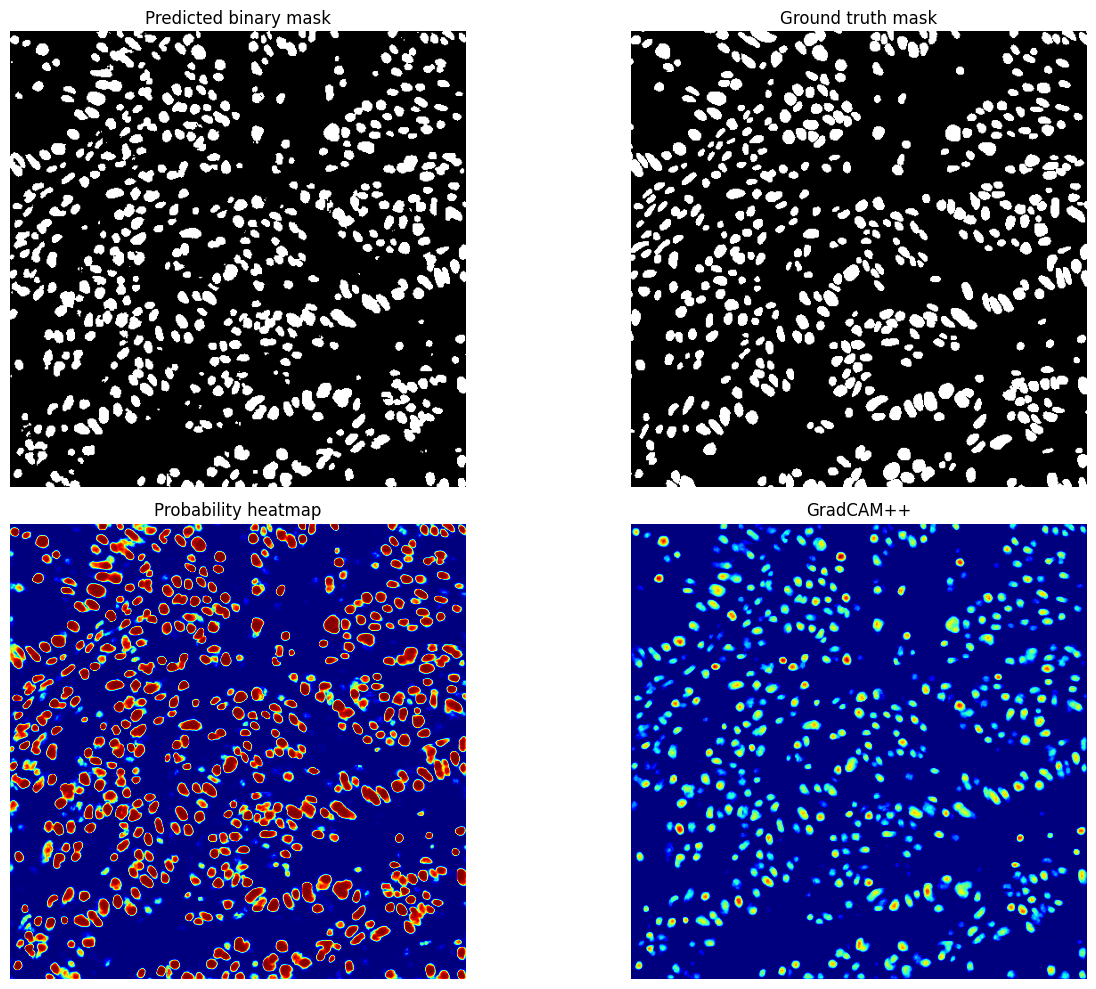

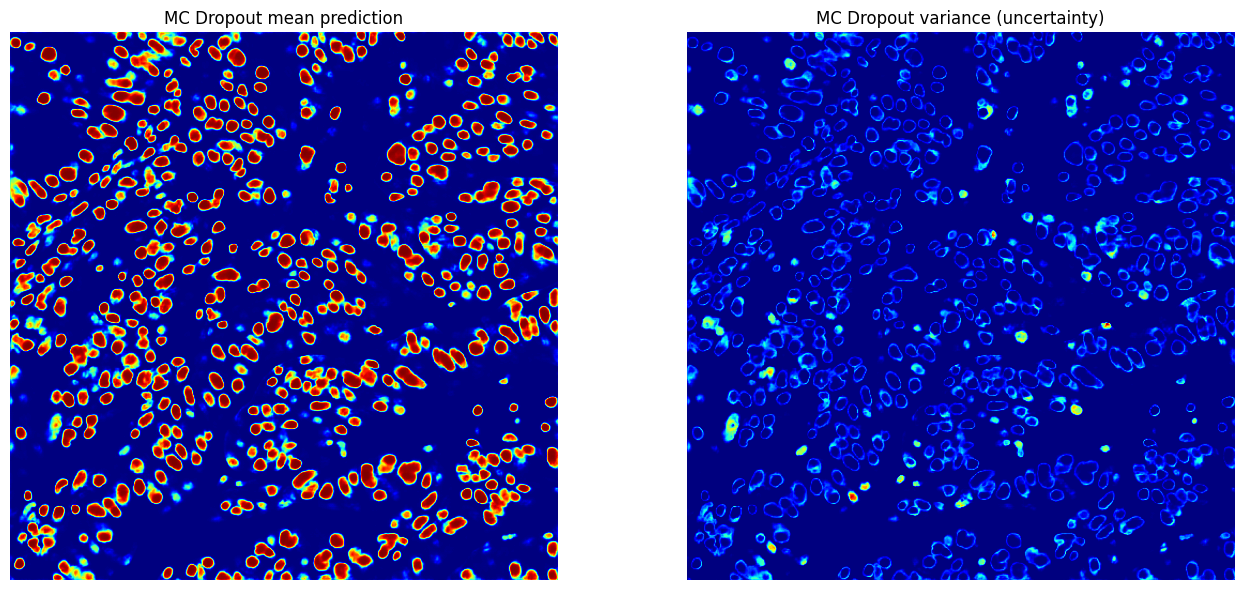

In [108]:
# visualize heatmaps and uncertainty for one test sample (baseline experiment)
best_model = UNet(n_channels=3, n_classes=1).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))

batch_imgs, batch_masks = next(iter(test_loader))
img = batch_imgs[0].unsqueeze(0).to(device)
mask_np = batch_masks[0][0].cpu().numpy()

# Heatmaps (probability + GradCAM++)
visualize_heatmaps(best_model, img, mask_np)

# MC Dropout uncertainty (mean prediction + variance)
mean_pred, var_pred = mc_dropout_prediction(best_model, img)
visualize_uncertainty(mean_pred, var_pred)

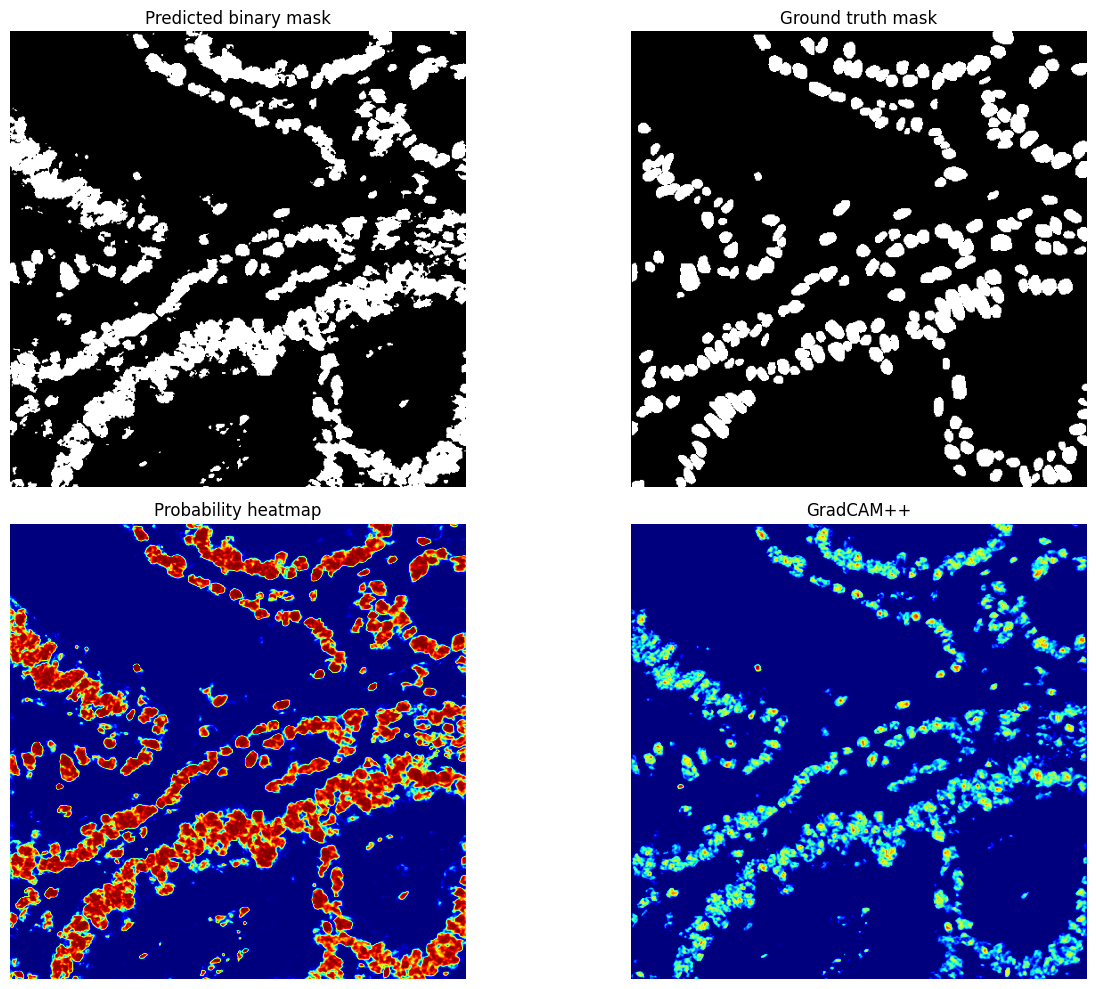

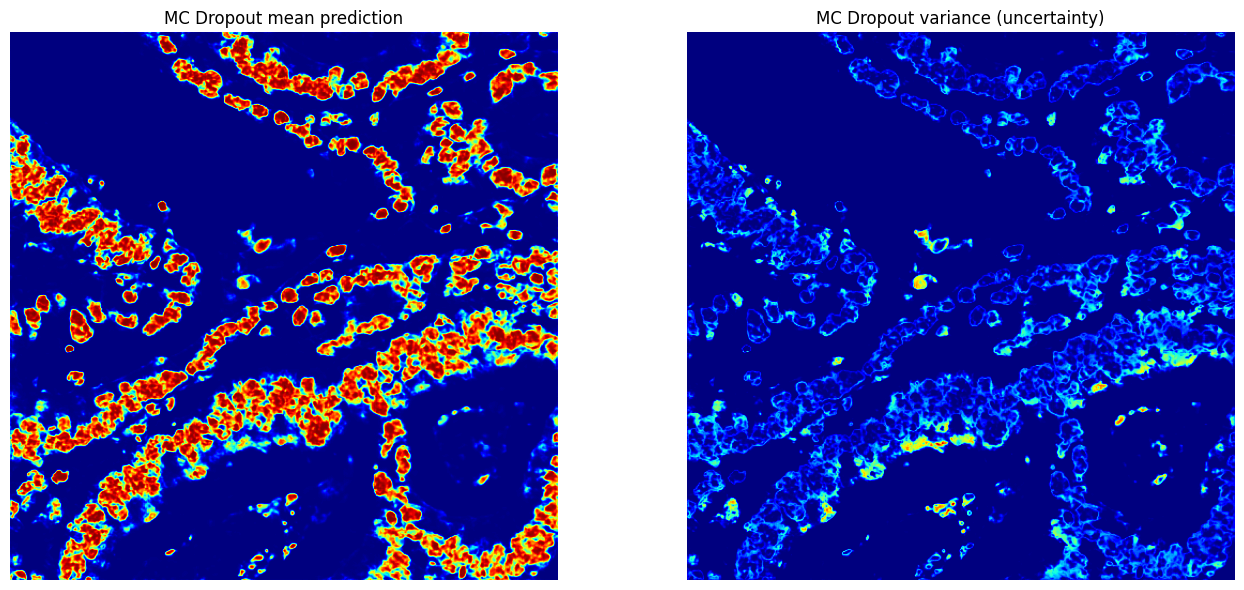

In [109]:
best_model_domains = UNet(n_channels=3, n_classes=1).to(device)
best_model_domains.load_state_dict(torch.load(best_model_path_domains, map_location=device))

batch_imgs_d, batch_masks_d = next(iter(test_loader_domains))
img_d = batch_imgs_d[0].unsqueeze(0).to(device)
mask_np_d = batch_masks_d[0][0].cpu().numpy()

visualize_heatmaps(best_model_domains, img_d, mask_np_d)

mean_pred_d, var_pred_d = mc_dropout_prediction(best_model_domains, img_d)
visualize_uncertainty(mean_pred_d, var_pred_d)